In [73]:
# UL on the UCI Wine dataset

import numpy as np
import pandas as pd
import time
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import sklearn
from sklearn import metrics, preprocessing, model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn import random_projection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras import optimizers, layers, regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(0)
rand = 2
data = pd.read_csv('redWine.csv')
#data = pd.read_csv('heart.csv')
Nclusters = 6
feats = list(data.columns.values)
truelabel = feats[-1]
print(truelabel)
data.info()

quality
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [57]:
X = data.drop([truelabel], axis=1)
y = data[truelabel]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=6)
X.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8


Error:   0.9130706691682301


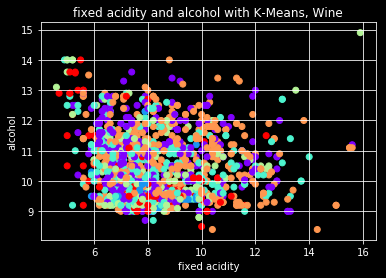

In [58]:
#Initial K-Means

km = KMeans(
    n_clusters=Nclusters, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=rand
).fit(X)
#print(km.labels_)
accur = np.mean(km.labels_ != y)
print('Error:  ', accur)
x_ax = 'fixed acidity'
y_ax = 'alcohol'
plt.style.use('dark_background')
ax=plt.axes()
ax.grid()
plt.title('{} and {} with K-Means, Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(X[x_ax],X[y_ax], c=km.labels_, cmap='rainbow')
plt.savefig('wine_kmeans_only.png')

Accuracy:   0.9906191369606003


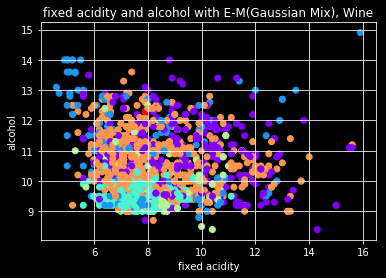

In [59]:
#Initial Gaussian Mixture (Expectation Maximization)

gm = GaussianMixture(n_components=Nclusters, n_init=10, random_state=rand)
gm.fit(X)
labels = gm.predict(X)
#print(labels)
accur = np.mean(labels != y)
print('Accuracy:  ', accur)
x_ax = 'fixed acidity'
y_ax = 'alcohol'
plt.style.use('dark_background')
ax=plt.axes()
ax.grid()
plt.title('{} and {} with E-M(Gaussian Mix), Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(X[x_ax],X[y_ax], c=labels, cmap='rainbow')
plt.savefig('wine_EM_only.png')

[0.94657698 0.0483683 ]


,principal component 1,principal component 2
0,-13.224905,-2.023900
1,22.037724,4.408322
2,7.162673,-2.501461


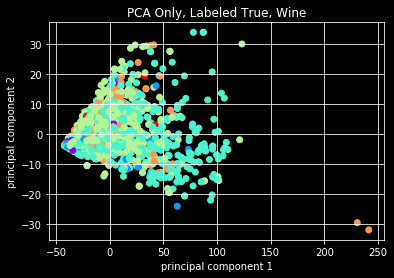

In [60]:
#PCA Only

#SX = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=rand)
X2D = pca.fit_transform(X)
pcaDf = pd.DataFrame(data = X2D
             , columns = ['principal component 1', 'principal component 2'])
#principalDf.info()
print(pca.explained_variance_ratio_)
x_ax = 'principal component 1'
y_ax = 'principal component 2'
plt.style.use('dark_background')
ax = plt.axes()
ax.grid()
plt.title('PCA Only, Labeled True, Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(pcaDf[x_ax],pcaDf[y_ax], c=y, cmap='rainbow')
plt.savefig('wine_PCA_only.png')
pcaDf.head(3)

Accuracy:   0.9155722326454033


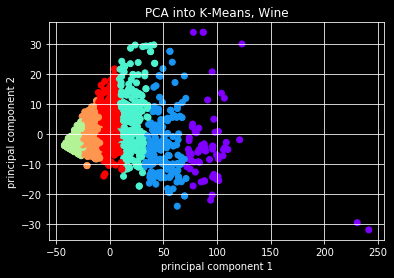

In [61]:
#PCA >>>> K Means

km = KMeans(
    n_clusters=Nclusters, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=rand
).fit(pcaDf)
#print(km.labels_)
accur = np.mean(km.labels_ != y)
print('Accuracy:  ', accur)
#x_ax = 'x'
#y_ax = 'y'
plt.style.use('dark_background')
ax=plt.axes()
ax.grid()
plt.title('PCA into K-Means, Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(pcaDf[x_ax],pcaDf[y_ax], c=km.labels_, cmap='rainbow')
plt.savefig('wine_PCA_kmeans.png')

Accuracy:   0.9893683552220137


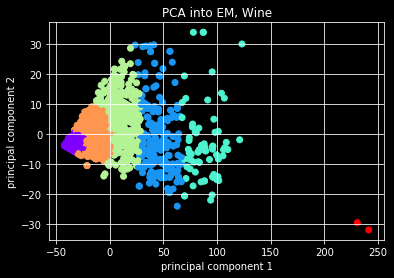

In [62]:
#PCA >>>> Gaussian Mixture (Expectation Maximization)

gm = GaussianMixture(n_components=Nclusters, n_init=10, random_state=rand)
gm.fit(pcaDf)
labels = gm.predict(pcaDf)
#print(labels)
accur = np.mean(labels != y)
print('Accuracy:  ', accur)
#x_ax = 'x'
#y_ax = 'y'
plt.style.use('dark_background')
ax=plt.axes()
ax.grid()
plt.title('PCA into EM, Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(pcaDf[x_ax],pcaDf[y_ax], c=labels, cmap='rainbow')
plt.savefig('wine_PCA_EM.png')

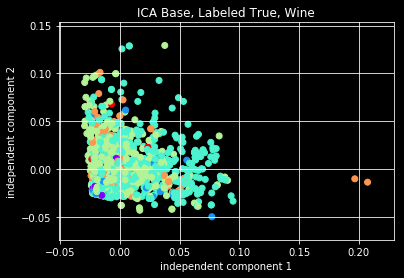

In [63]:
#ICA Only

ica = FastICA(n_components=2, random_state=rand)
X2D = ica.fit_transform(X)
icaDf = pd.DataFrame(data = X2D
             , columns = ['independent component 1', 'independent component 2'])
#plotDf.info()
#print(ica.mixing_)

x_ax = 'independent component 1'
y_ax = 'independent component 2'
plt.style.use('dark_background')
ax=plt.axes()
ax.grid()
plt.title('ICA Base, Labeled True, Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(icaDf[x_ax],icaDf[y_ax], c=y, cmap='rainbow')
plt.savefig('wine_ICA_only.png')

Accuracy:   0.9362101313320825


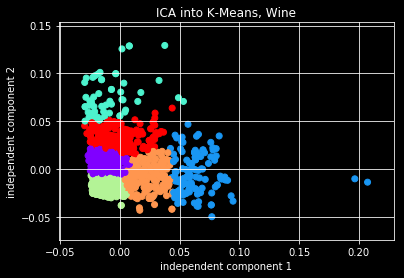

In [64]:
#ICA >>>> K Means

km = KMeans(
    n_clusters=Nclusters, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=rand
).fit(icaDf)
#print(km.labels_)
accur = np.mean(km.labels_ != y)
print('Accuracy:  ', accur)
#x_ax = 'x'
#y_ax = 'y'
plt.style.use('dark_background')
ax=plt.axes()
ax.grid()
plt.title('ICA into K-Means, Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(icaDf[x_ax],icaDf[y_ax], c=km.labels_, cmap='rainbow')
plt.savefig('wine_ICA_kmeans.png')

Accuracy:   0.9255784865540964


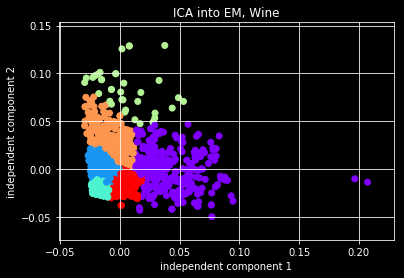

In [65]:
#ICA >>>> Gaussian Mixture (Expectation Maximization)

gm = GaussianMixture(n_components=Nclusters, n_init=10, random_state=rand)
gm.fit(icaDf)
labels = gm.predict(icaDf)
#print(labels)
accur = np.mean(labels != y)
print('Accuracy:  ', accur)
#x_ax = 'x'
#y_ax = 'y'
plt.style.use('dark_background')
ax=plt.axes()
ax.grid()
plt.title('ICA into EM, Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(icaDf[x_ax],icaDf[y_ax], c=labels, cmap='rainbow')
plt.savefig('wine_ICA_EM.png')

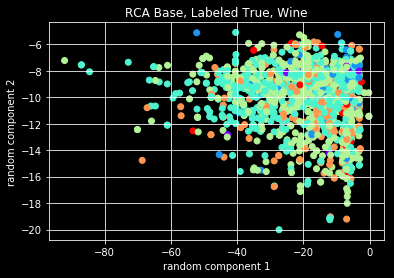

In [66]:
#RCA Only

rca = random_projection.SparseRandomProjection(n_components=2, random_state=rand) #changed random state for better results
X2D = rca.fit_transform(X)
rcaDf = pd.DataFrame(data = X2D
             , columns = ['random component 1', 'random component 2'])
#plotDf.info()
#print()

x_ax = 'random component 1'
y_ax = 'random component 2'
plt.style.use('dark_background')
ax=plt.axes()
ax.grid()
plt.title('RCA Base, Labeled True, Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(rcaDf[x_ax],rcaDf[y_ax], c=y, cmap='rainbow')
plt.savefig('wine_RCA_only.png')

Accuracy:   0.9205753595997499


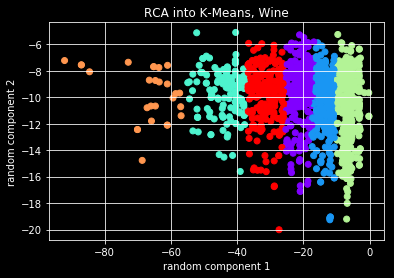

In [67]:
#RCA >>>> K Means

km = KMeans(
    n_clusters=Nclusters, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=rand
).fit(rcaDf)
#print(km.labels_)
accur = np.mean(km.labels_ != y)
print('Accuracy:  ', accur)
#x_ax = 'x'
#y_ax = 'y'
plt.style.use('dark_background')
ax=plt.axes()
ax.grid()
plt.title('RCA into K-Means, Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(rcaDf[x_ax],rcaDf[y_ax], c=km.labels_, cmap='rainbow')
plt.savefig('wine_RCA_kmeans.png')

Accuracy:   0.8805503439649781


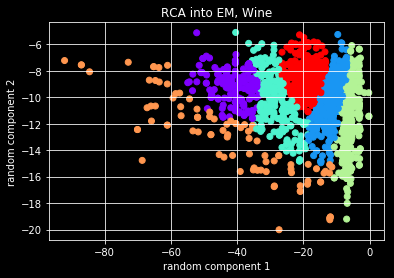

In [68]:
#RCA >>>> Gaussian Mixture (Expectation Maximization)

gm = GaussianMixture(n_components=Nclusters, n_init=10, random_state=rand)
gm.fit(rcaDf)
labels = gm.predict(rcaDf)
#print(labels)
accur = np.mean(labels != y)
print('Accuracy:  ', accur)
#x_ax = 'x'
#y_ax = 'y'
plt.style.use('dark_background')
ax=plt.axes()
ax.grid()
plt.title('RCA into EM, Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(rcaDf[x_ax],rcaDf[y_ax], c=labels, cmap='rainbow')
plt.savefig('wine_RCA_EM.png')

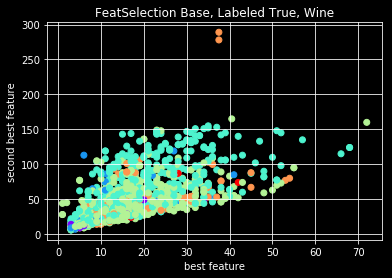

In [69]:
# Feature Selection:  kBest Features, Univariate feature selection
# Select the k best features based on univariate statistical tests

ufs = SelectKBest(chi2, k=2)
X2D = ufs.fit_transform(X,y)

ufsDf = pd.DataFrame(data = X2D
             , columns = ['best feature', 'second best feature'])
#ufsDf.info()

x_ax = 'best feature'
y_ax = 'second best feature'
plt.style.use('dark_background')
ax=plt.axes()
ax.grid()
plt.title('FeatSelection Base, Labeled True, Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(ufsDf[x_ax],ufsDf[y_ax], c=y, cmap='rainbow')
plt.savefig('wine_kbest_only.png')

Accuracy:   0.9174484052532833


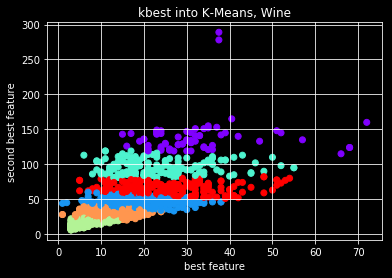

In [70]:
#kBest Features >>>> K Means

km = KMeans(
    n_clusters=Nclusters, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
).fit(ufsDf)
#print(km.labels_)
accur = np.mean(km.labels_ != y)
print('Accuracy:  ', accur)
#x_ax = 'x'
#y_ax = 'y'
plt.style.use('dark_background')
ax=plt.axes()
ax.grid()
plt.title('kbest into K-Means, Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(ufsDf[x_ax],ufsDf[y_ax], c=km.labels_, cmap='rainbow')
plt.savefig('wine_kbest_kmeans.png')

Accuracy:   0.926829268292683


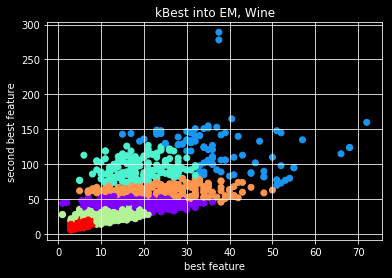

In [71]:
#kBest Features >>>> Gaussian Mixture (Expectation Maximization)

gm = GaussianMixture(n_components=Nclusters, n_init=10, random_state=0)
gm.fit(ufsDf)
labels = gm.predict(ufsDf)
#print(labels)
accur = np.mean(labels != y)
print('Accuracy:  ', accur)
#x_ax = 'x'
#y_ax = 'y'
plt.style.use('dark_background')
ax=plt.axes()
ax.grid()
plt.title('kBest into EM, Wine'.format(x_ax, y_ax))
plt.xlabel('{}'.format(x_ax))
plt.ylabel('{}'.format(y_ax))
plt.scatter(ufsDf[x_ax],ufsDf[y_ax], c=labels, cmap='rainbow')
plt.savefig('wine_kbest_EM.png')